In [113]:
#import libraries
# import tensorflow as tf
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image, ImageDraw, ImageFont
import numpy as np

from utils import cutout

import matplotlib as plt

#Task2

In [91]:
# functions to show an image

# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

## cifar-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 16
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform= transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imgs = []
# show images
for i in range(len(images)):

    img = (images[i]/2 +.5)*100  # unnormalize
    im = img.cpu().detach().numpy()
    # im = img.numpy()
    im = np.transpose(im, (1,2,0))
    im = np.uint8(im)
    imgs.append(Image.fromarray(im, 'RGB')) 


    
    
    


# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Files already downloaded and verified
horse   dog  deer   dog plane  deer  frog   car  frog   dog  bird  bird   dog  frog   cat   dog


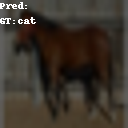

In [126]:
imgs = []
# show images
for i in range(len(images)):

    img = (images[i]/2 +.5)*100  # unnormalize
    im = img.cpu().detach().numpy()
    im = np.transpose(im, (1,2,0))
    im = np.uint8(im)
    im = Image.fromarray(im, 'RGB')
    im = im.resize((128,128))
    im_draw = ImageDraw.Draw(im)
    
    gt = "\nGT:"
    pd = "Pred:"
    tv = classes[labels[0]]
    text = pd + gt + tv
    fontsize = 1
    im_draw.text((0,0),text)

    imgs.append(im)


imgs[0]

# collage = Image.new('RGB', (32, 32*len(imgs)))
# for i in range(len(imgs)):
#     collage.paste(imgs[i], (0,32*i))
#     collage.save('test.png')


In [122]:
img = (images[0]/2 +.5)*100  # unnormalize
im = img.cpu().detach().numpy()
# im = img.numpy()
im = np.transpose(im, (1,2,0))
im = np.uint8(im)
im = Image.fromarray(im, 'RGB')
im = im.resize((128,128))

im_draw = ImageDraw.Draw(im)
gt = "\nGT:"
pd = "Pred:"
tv = classes[labels[0]]
text = pd + gt + tv
fontsize = 1
# imgs.append(Image.fromarray(im, 'RGB'))

im_draw.text((0,0),text)

im.save('test.png')

In [14]:
#implement DenseNet architecture into image classification tutorial
class Dense_Layer(nn.Module):
    def __init__(self, n_in, n_out):
        super(Dense_Layer, self).__init__()
        self.bn = nn.BatchNorm2d(n_in)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(n_in, n_out, kernel_size=3, stride=1, padding=1, bias=False)
    
    def forward(self,x):
        out = self.conv(self.relu(self.bn(x)))
        out = torch.cat([out,x],1)
        return out

class Transition_Layer(nn.Sequential):
    def __init__(self, n_in, n_out):
        super(Transition_Layer, self).__init__()
        self.bn = nn.BatchNorm2d(n_in)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(n_in, n_out,kernel_size=1,stride=1,padding = 0,bias=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.pool(self.conv(self.relu(self.bn(x))))
        return x

class Dense_Block(nn.Module):
    def __init__(self, n_in, growth):
        super(Dense_Block, self).__init__()
        self.layer = self.dense_block(n_in, growth)
    def dense_block(self, n_in, growth):
        layers = []
        for i in range(0,4):
            layers.append(Dense_Layer(n_in + i*growth, growth))
        return nn.Sequential(*layers)
    def forward(self,x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self):
        super(DenseNet3, self).__init__()
        #initial convolution
        self.conv0 = nn.Conv2d(3, 6, kernel_size=3, stride = 1, padding=1, bias=False)
        
        #first denseblock
        self.dense1 = Dense_Block(n_in = 6, growth = 16)
        #note since there are 4 layers the output of denseblock will have 6 +4*16 channels
        self.trans1 = Transition_Layer(n_in = 70, n_out = 35)

        #second denseblock
        self.dense2 = Dense_Block(n_in = 35, growth = 16)
        #note since there are 4 layers the output of denseblock will have 35 + 4*16
        self.trans2 = Transition_Layer(n_in = 99, n_out=50)

        #third denseblock
        self.dense3 = Dense_Block(n_in=50,growth=16)

        #global average pooling, classifier
        self.bnend =  nn.BatchNorm2d(114)
        self.classifier = nn.Linear(114, 10)

        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.constant_(m.bias,0)

    def forward(self,x):
        out = self.conv0(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = F.relu(self.bnend(out))
        out = F.adaptive_avg_pool2d(out, (1,1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out

In [19]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#print cutout images
image_ls = []

for i,x in enumerate(images):

    new_image = cutout(1,32,x)

    image_ls.append(new_image)
    

new_images = torch.stack(image_ls)

ims = Image.getIm(torchvision.utils.make_grid(new_images))

ims.show()

AttributeError: 'Tensor' object has no attribute 'read'

In [127]:
if __name__ == '__main__':
    ## cifar-10 dataset
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 40

    #get training set
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    #get test set
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    #declare classes
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


    ## densenet
    net = DenseNet3()
    ##print model architexture
    print("Model Architecture:")
    print("\n",net)

    #define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=.001, momentum =.9)

    #initialize empty vectors to store values
    train_accuracy = []
    train_losses =  []
    test_accuracy = []
    test_losses = []

    ## train
    for epoch in range(10):  # loop over the dataset multiple times

        print(f'Starting Epoch {epoch+1}')

        #train
        running_loss = 0.0
        correct = 0.0
        total = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            #insert cutout algorithm into training
            cutouts = []
            for j,x in enumerate(inputs):
                new_image = cutout(1,32,x)
                cutouts.append(new_image)
            
            inputs = torch.stack(cutouts)

            #save cutout image for first batch
            if(epoch == 0):
                if (i == 0):

                    imgs = []
                    # get images
                    for i in range(len(inputs)):

                        img = (inputs[i]/2 +.5)*100  # unnormalize
                        im = img.cpu().detach().numpy()
                        # im = img.numpy()
                        im = np.transpose(im, (1,2,0))
                        im = np.uint8(im)
                        imgs.append(Image.fromarray(im, 'RGB'))

                    #create collage
                    collage = Image.new('RGB', (32, 32*16))
                    for i in range(16):
                        collage.paste(imgs[i], (0,32*i))
                        collage.save('cutout.png')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            _,predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        
        train_loss = running_loss/len(trainloader)
        train_accu = 100.*correct/total

        print('Train Loss: %.3f | Train Accuracy: %.3f'%(train_loss,train_accu),'%')

        #test
        running_loss = 0.0
        correct = 0.0
        total = 0

        #forward pass only
        with torch.no_grad():
            for i, data in enumerate(testloader,0):
                inputs, lables = data

                outputs = net(inputs)

                loss = criterion(outputs,labels)
                running_loss+=loss.item()

                _,predicted = outputs.max(1)
                total += labels.size(0)
                correct +=predicted.eq(labels).sum().item()

                #save a png of results 
                if (epoch == 10):
                    if (i == 0):
                        imgs = []
                        # get images
                        for i in range(len(inputs)):

                            img = (images[i]/2 +.5)*100  # unnormalize
                            im = img.cpu().detach().numpy()
                            im = np.transpose(im, (1,2,0))
                            im = np.uint8(im)
                            im = Image.fromarray(im, 'RGB')
                            im = im.resize((128,128))
                            im_draw = ImageDraw.Draw(im)
    
                            gt = "\nGT:"
                            pd = "Pred:"
                            tv = classes[labels[0]]
                            yh = classes[predicted[0]]
                            text = pd + yh + gt + tv
                            fontsize = 1
                            im_draw.text((0,0),text)

                            imgs.append(im)

                        #create collage
                        collage = Image.new('RGB', (128, 128*36))
                        for i in range(36):
                            collage.paste(imgs[i], (0,128*i))
                            collage.save('results.png')

        test_loss = running_loss/len(testloader)
        test_accu = 100.*correct/total

        test_losses.append(test_loss)
        test_accuracy.append(test_accu)

        print('Test Loss: %.3f | Test Accuracy: %.3f'%(test_loss,test_accu),'%')
                    

    print('Training done.')

    # save trained model
    torch.save(net.state_dict(), 'saved_model.pt')
    print('Model saved.')

Files already downloaded and verified
Files already downloaded and verified
Model Architecture:

 DenseNet3(
  (conv0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Dense_Block(
    (layer): Sequential(
      (0): Dense_Layer(
        (bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Dense_Layer(
        (bn): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(22, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (2): Dense_Layer(
        (bn): BatchNorm2d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(38, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

ValueError: Expected input batch_size (40) to match target batch_size (20).